## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_unit=10, num=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n in enumerate(num):
        if i ==0:
            x = keras.layers.Dense(units=n, activation='relu', name='hidden_layer'+str(i))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n, activation='relu', name='hidden_layer'+str(i))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_unit, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### ModelCheckpoint
- filepath: 字串，保存模型的路徑。
- monitor: 被監測的資料。
- verbose: 詳細資訊模式，0 或者 1 。
- save_best_only: 如果 save_best_only=True， 被監測資料的最佳模型就不會被覆蓋。
- save_weights_only: 如果 True，那麼只有模型的權重會被保存 (model.save_weights(filepath))， 否則的話，整個模型會被保存 (model.save(filepath))。
- period: 每個檢查點之間的間隔（訓練輪數）。


#### save_best_only=True

In [7]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
"""Code Here
設定 callbacks: model checkpoint
"""

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 5s 103us/step - loss: 0.5023 - acc: 0.8598 - val_loss: 1.6949 - val_acc: 0.4866
Epoch 50/50
10000/10000 [==============================] - 2s 189us/step


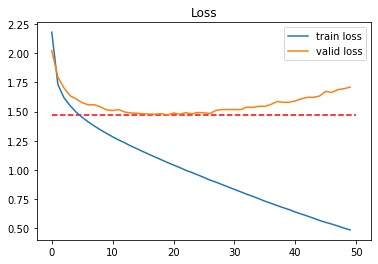

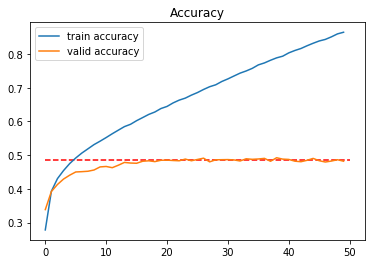

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

#### save_best_only=False

In [10]:
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.0428 - acc: 0.6467 - val_loss: 1.5010 - val_acc: 0.4827
Epoch 2/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.0222 - acc: 0.6544 - val_loss: 1.4761 - val_acc: 0.4915
Epoch 3/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.0002 - acc: 0.6609 - val_loss: 1.4908 - val_acc: 0.4839
Epoch 4/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.9777 - acc: 0.6684 - val_loss: 1.4858 - val_acc: 0.4864
Epoch 5/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9558 - acc: 0.6797 - val_loss: 1.4893 - val_acc: 0.4851
Epoch 6/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.9349 - acc: 0.6872 - val_loss: 1.4881 - val_acc: 0.4873
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.9146 - acc: 0.6945 - val_loss: 1.4884 - 

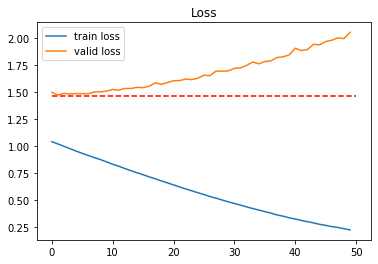

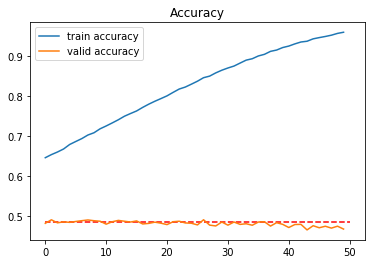

In [11]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

#### save_weights_only=True

In [15]:
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_weights_only=True)
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# Load back
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.0326 - acc: 0.9995 - val_loss: 2.7107 - val_acc: 0.4709
Epoch 2/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.0311 - acc: 0.9997 - val_loss: 2.7234 - val_acc: 0.4692
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 0.0307 - acc: 0.9997 - val_loss: 2.7681 - val_acc: 0.4696
Epoch 4/50
50000/50000 [==============================] - 6s 120us/step - loss: 0.0293 - acc: 0.9998 - val_loss: 2.7515 - val_acc: 0.4744
Epoch 5/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.0287 - acc: 0.9998 - val_loss: 2.7640 - val_acc: 0.4674
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 0.0282 - acc: 0.9998 - val_loss: 2.7575 - val_acc: 0.4697
Epoch 7/50
50000/50000 [==============================] - 6s 112us/step - loss: 0.0272 - acc: 0.9999 - val_loss: 2.7759 - 

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

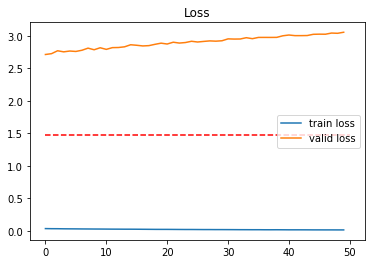

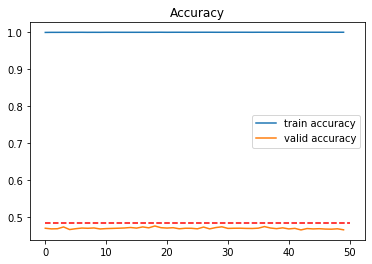

In [16]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

### Result
- save_best_only顧名思義會將最佳模型儲存下來
- save_weight_only只保留參數, 不保留模型